In [1]:
import time
start = time.perf_counter()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

Source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000201

In [4]:
df = pd.read_csv('../data/monthly_avg_retail_price_food_canada.csv')
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [5]:
df.shape

(16166, 15)

In [6]:
df = df[df['Products'] == 'Round steak, 1 kilogram']
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [7]:
df.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='str')

In [8]:
cols_to_drop = ['GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS']

df = df.drop(cols_to_drop, axis=1)
df.head()

,REF_DATE,VALUE
0,1995-01,10.17
1,1995-02,10.29
2,1995-03,10.12
3,1995-04,10.38
4,1995-05,10.00


In [9]:
df.shape

(323, 2)

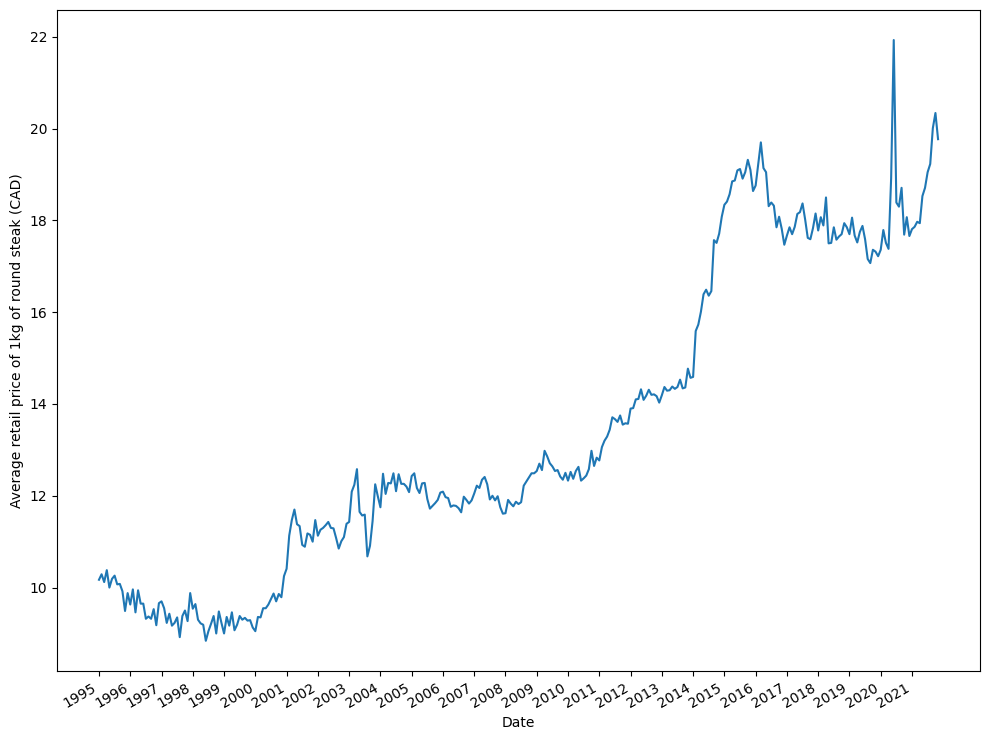

In [10]:
fig, ax = plt.subplots()

ax.plot(df['VALUE'])
ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F01_peixeiro.png', dpi=300)

In [11]:
df.columns = ['ds', 'y']

In [12]:
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

,ds,y
0,1995-01-31,10.17
1,1995-02-28,10.29
2,1995-03-31,10.12
3,1995-04-30,10.38
4,1995-05-31,10.00


In [13]:
train = df[:-36]
test = df[-36:]

train.tail()

,ds,y
282,2018-07-31,17.85
283,2018-08-31,17.58
284,2018-09-30,17.65
285,2018-10-31,17.70
286,2018-11-30,17.94


In [14]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

cutoffs = pd.date_range(start='2000-01-31', end='2015-11-30', freq='36ME')       # instead of freq='36M', instead of  end='2018-11-30'

for param in params:
    m = Prophet(**param)
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


In [16]:
best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}

In [17]:
m = Prophet(**best_params)
m.fit(train);

20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = m.make_future_dataframe(periods=36, freq='ME')      # instead of freq='M'

In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
311,2020-12-31,19.173877,17.592711,21.066478
312,2021-01-31,19.169131,17.402425,21.296635
313,2021-02-28,19.500608,17.712690,21.823904
314,2021-03-31,19.425531,17.569782,21.566979
315,2021-04-30,19.551181,17.513531,21.979266
316,2021-05-31,19.494202,17.391340,22.138117
317,2021-06-30,19.419570,17.176507,21.943097
318,2021-07-31,19.380077,17.013513,22.157183
319,2021-08-31,19.366406,16.868651,22.395114
320,2021-09-30,19.375781,16.720419,22.411727


In [20]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
287,2018-12-31,17.85,18.577627,17.913797,19.278583
288,2019-01-31,17.70,18.562492,17.889747,19.222774
289,2019-02-28,18.06,18.745277,18.073161,19.454512
290,2019-03-31,17.67,18.771024,18.090805,19.502499
291,2019-04-30,17.52,19.022715,18.400637,19.705425


In [21]:
test['Baseline'] = train['y'].iloc[-1]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,Baseline
287,2018-12-31,17.85,18.577627,17.913797,19.278583,17.94
288,2019-01-31,17.70,18.562492,17.889747,19.222774,17.94
289,2019-02-28,18.06,18.745277,18.073161,19.454512,17.94
290,2019-03-31,17.67,18.771024,18.090805,19.502499,17.94
291,2019-04-30,17.52,19.022715,18.400637,19.705425,17.94


In [22]:
baseline_mae = mean_absolute_error(test['y'], test['Baseline'])
prophet_mae = mean_absolute_error(test['y'], test['yhat'])

print(prophet_mae)
print(baseline_mae)

1.146027843648268
0.6816666666666671


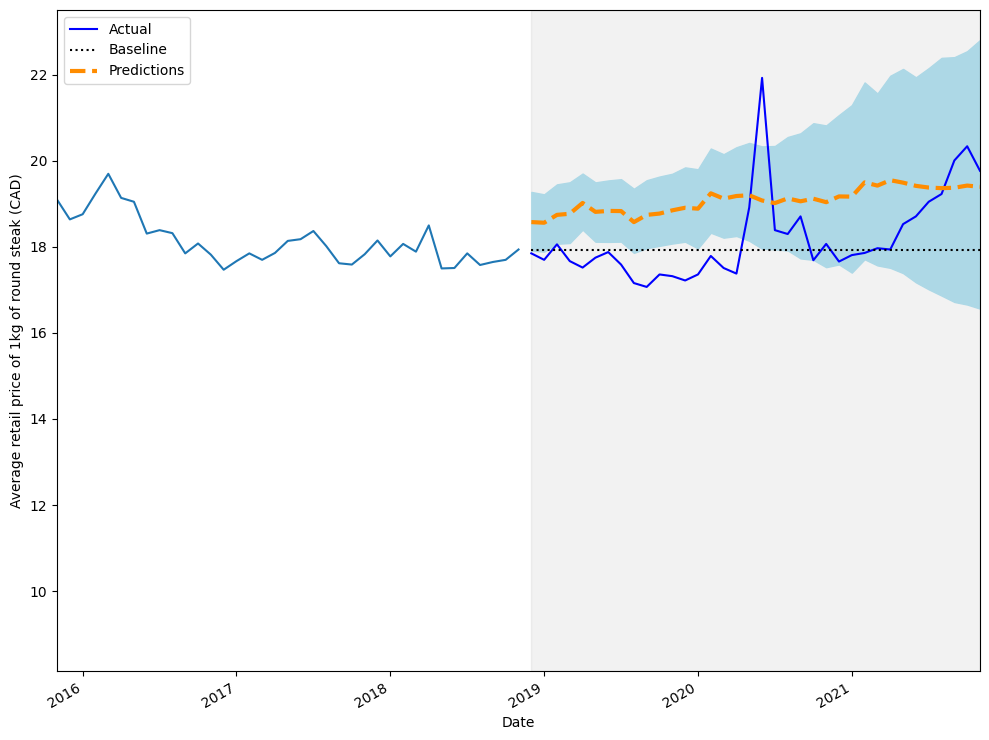

In [23]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F02_peixeiro.png', dpi=300)

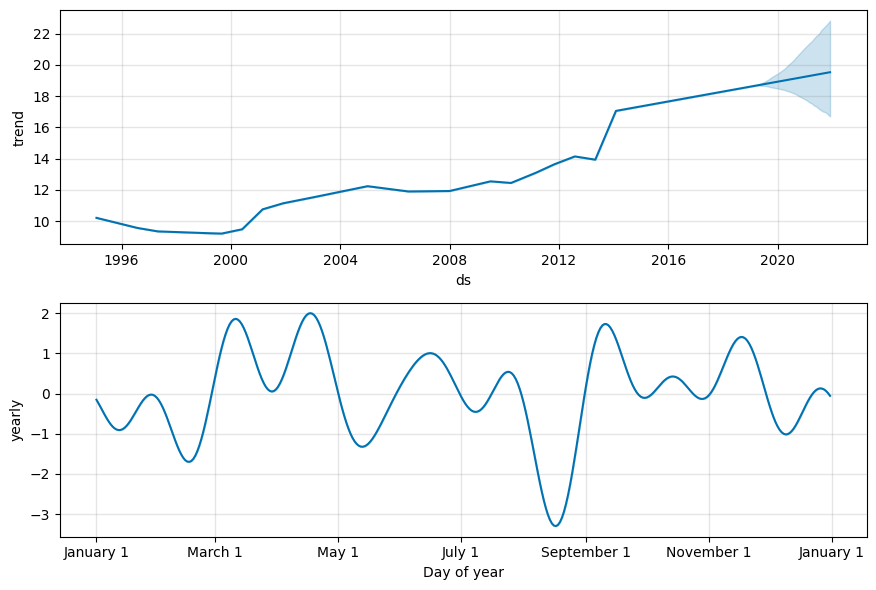

In [24]:
prophet_components_fig = m.plot_components(forecast)

plt.savefig('figures/CH20_F03_peixeiro.png', dpi=300)

## SARIMA 

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from typing import Union

In [26]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.3127660467739119
p-value: 0.9779226633224507


In [27]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.784744900608818
p-value: 1.2558701587332173e-29


In [28]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [29]:
ps = range(1, 4, 1)
qs = range(1, 4, 1)
Ps = range(1, 4, 1)
Qs = range(1, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

In [30]:
# SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
# SARIMA_result_df

SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)  
4m 38 seconds  

	    (p,q,P,Q)	AIC  
0	(2, 3, 1, 1)	59.405038  
1	(2, 3, 1, 2)	60.353975   
2	(3, 2, 1, 1)	60.714217   
3	(2, 3, 2, 1)	60.911389   
4	(3, 2, 2, 1)	61.962410    
5	(2, 3, 3, 1)	62.074363   
6	(2, 2, 1, 1)	62.111793  
7	(2, 3, 1, 3)	62.176071   
8	(1, 2, 1, 1)	62.594648   
9	(1, 1, 1, 1)	63.128863  
10	(2, 1, 1, 1)	63.311825   
11	(3, 2, 1, 3)	63.589551   
12	(3, 2, 1, 2)	63.989466  
13	(2, 2, 2, 1)	64.135257  
14	(3, 1, 1, 1)	64.226285   
15	(1, 3, 1, 1)	64.377932  
16	(1, 2, 2, 1)	64.391174   
17	(1, 2, 1, 2)	64.393763  
18	(2, 2, 1, 2)	64.668778  
19	(1, 1, 1, 2)	65.047108  

In [31]:
SARIMA_model = SARIMAX(train['y'], order=(2,1,3), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  287
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 -21.703
Date:                              Fri, 20 Feb 2026   AIC                             59.405
Time:                                      20:27:15   BIC                             88.653
Sample:                                           0   HQIC                            71.128
                                              - 287                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2300      0.040     30.943      0.000       1.152       1.308
ar.L2         -0.92

/home/minty/Repos/z3.12/z12_uv_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


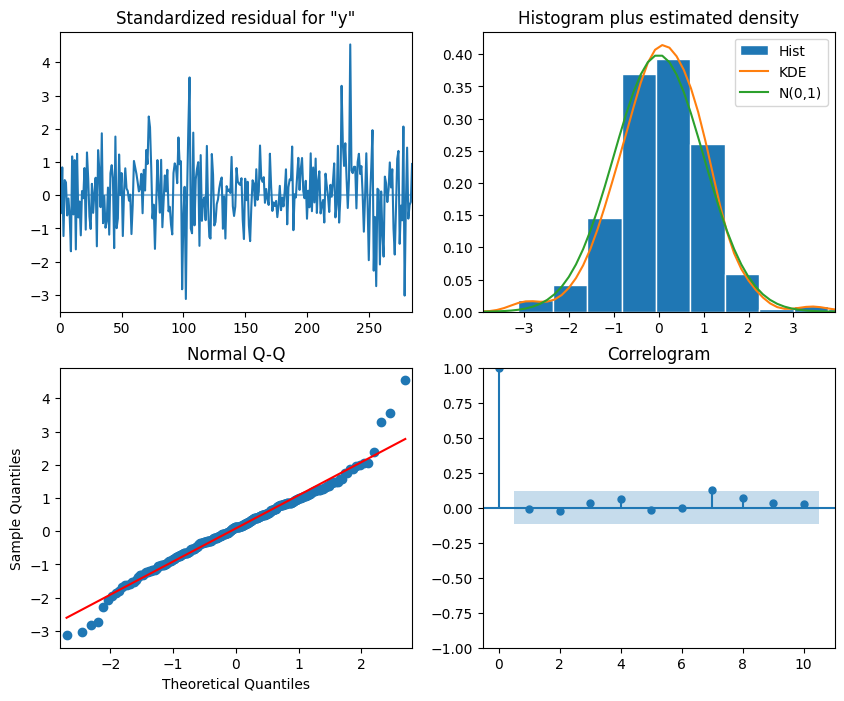

In [32]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH20_F04_peixeiro.png', dpi=300)

In [33]:
# residuals = SARIMA_model_fit.resid

# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)

In [34]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.011418,0.914902
2,0.102598,0.949995
3,0.243885,0.970212
4,0.360800,0.985559
5,0.368487,0.996153
6,0.379842,0.999009
7,0.384614,0.999769
8,0.398452,0.999944
9,0.436493,0.999983
10,0.838628,0.999924


In [35]:
SARIMA_pred = SARIMA_model_fit.get_prediction(287, 322).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

In [36]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])

print(SARIMA_mae)

0.6787884131728754


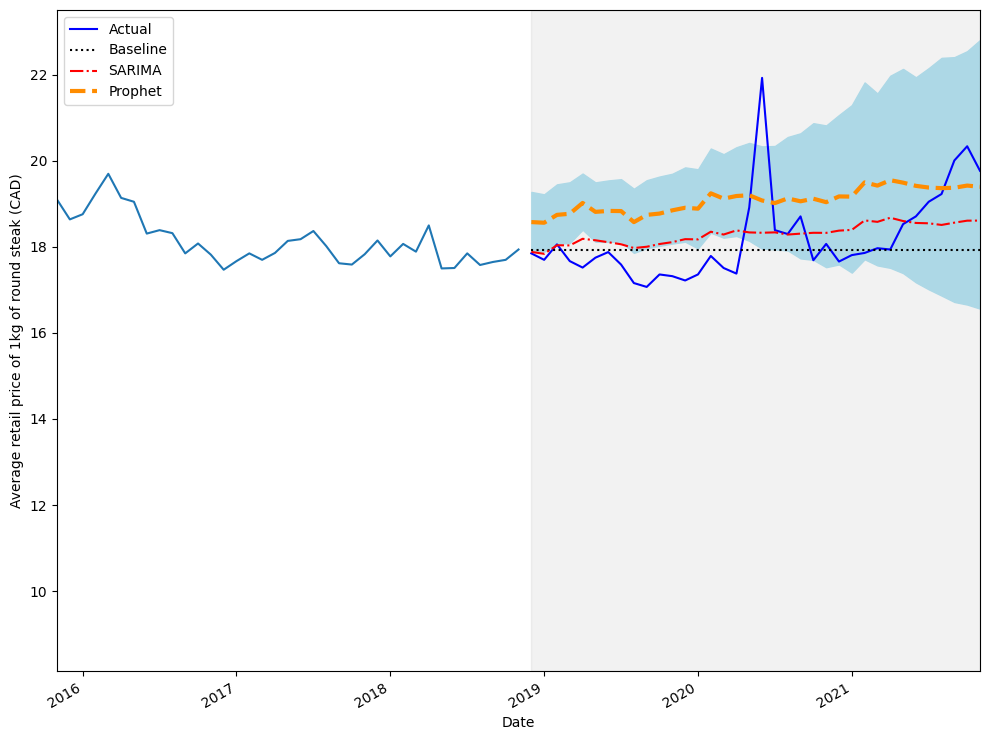

In [37]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['SARIMA_pred'], 'r-.', label='SARIMA')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Prophet')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH20_F05_peixeiro.png', dpi=300)

In [38]:
end = time.perf_counter()

elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 19.2409 seconds


Elapsed time: 19.2409 seconds + 4min 38 seconds of Optimize Sarima